# Modelo RNN

### Se importan librerías necesarias

In [1]:
# !pip install tensorflow==2.15.0

In [2]:
import os
# os.environ["SM_FRAMEWORK"] = "tf.keras"
import pathlib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
# import seaborn as sns
import datetime as dt
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.models import load_model

########
########

2.15.0


In [3]:

# Conexión de google drive con el repo
from google.colab import drive
drive.mount('/content/drive')
ruta = os.path.join("/content/drive/MyDrive","MonografiaUdeA")
os.chdir(ruta)

###==========================
abspath = pathlib.Path.cwd()
print(f"Directorio de trabajo: {abspath}")
###==========================

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Directorio de trabajo: /content/drive/MyDrive/MonografiaUdeA


In [4]:
def parse(x):
    return dt.datetime.strptime(x, '%Y-%m-%d')

def get_dataset():
    dataset = pd.read_csv(os.path.join(abspath,"datasets", "procesado", "3_dataset_filtrado.csv"), index_col=0, date_parser=parse)
    # dataset = pd.read_csv("https://raw.githubusercontent.com/cjusquini/MonografiaUdeA/main/datasets/procesado/3_dataset_filtrado.csv", index_col=0, date_parser=parse)
    # df = dataset.copy()
    return dataset

df = get_dataset()
df.head()

,precio_bolsa,demanda,disp_dec_hidraulica,disp_dec_termica,gen_hidraulica,gen_no_termica,gen_termica,aportes_energia,precio_oferta,vol_util,indice_ONI,vertimientos
fecha,,,,,,,,,,,,
2010-01-01,120.501228,1.133616e+08,356125.000000,121611.607143,35796804.67,13362226.83,66260052.96,45616100.0,267.437633,1.000661e+10,1.5,0.0
2010-01-02,118.495340,1.254718e+08,353776.515152,121633.928571,46595646.99,13393741.63,67691806.16,43097100.0,277.153592,9.995147e+09,1.5,0.0
2010-01-03,121.160145,1.211452e+08,356579.545455,119455.357143,42578875.20,13046074.83,68012828.41,43400400.0,313.552755,9.992677e+09,1.5,0.0
2010-01-04,123.962937,1.439317e+08,341617.424242,116611.607143,62242326.79,13160643.95,70554488.25,40410400.0,303.519878,9.965341e+09,1.5,0.0
2010-01-05,120.666437,1.498691e+08,346125.000000,116613.095238,69173462.65,14514419.15,68460147.29,41190600.0,339.600449,9.926760e+09,1.5,0.0


In [5]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
scaled_df.head(5)

,precio_bolsa,demanda,disp_dec_hidraulica,disp_dec_termica,gen_hidraulica,gen_no_termica,gen_termica,aportes_energia,precio_oferta,vol_util,indice_ONI,vertimientos
fecha,,,,,,,,,,,,
2010-01-01,0.044641,0.000000,0.654490,0.612788,0.000000,0.755503,0.665266,0.029498,0.144822,0.484812,0.738095,0.0
2010-01-02,0.043589,0.120600,0.645406,0.613112,0.074578,0.757482,0.682814,0.025017,0.162552,0.483498,0.738095,0.0
2010-01-03,0.044986,0.077513,0.656248,0.581456,0.046838,0.735654,0.686748,0.025557,0.228976,0.483215,0.738095,0.0
2010-01-04,0.046456,0.304433,0.598374,0.540133,0.182635,0.742847,0.717898,0.020238,0.210667,0.480082,0.738095,0.0
2010-01-05,0.044727,0.363560,0.615809,0.540155,0.230502,0.827840,0.692230,0.021626,0.276509,0.475660,0.738095,0.0


### División de datos en entrenamiento y prueba

In [6]:
from _functions import create_sequences, split_data

### Creación de arquitectura de modelos

In [7]:
from _functions import create_model

In [8]:
retardos = [60]
neurons = [30, 40]
modelos_implementar = ['RNN']
elementos_a_predecir = [31]
optimizers = ['adam']
losses = ['mse']
epochs = [100]
batch_size = [64, 32]
_learning_rate = 1e-4

In [9]:
# for retardo in retardos:
#     print("retardo",retardo, "dimensiones",train_data[retardo][0].shape, test_data[retardo][0].shape)

In [10]:
#Se inicializa la semilla
np.random.seed(2)
tf.random.set_seed(2)
tf.compat.v1.set_random_seed(2)

In [11]:

train_data, test_data = split_data(lags = retardos, scaled_df = scaled_df, train_test_split_ratio = 0.8)

models_with_var = {lag: {} for lag in retardos}

lag_grid, model_grid, optimizer_grid, loss_grid, element_grid, neurons_grid = np.meshgrid(retardos, modelos_implementar, optimizers, losses, elementos_a_predecir, neurons)
lag_grid = lag_grid.flatten()
model_grid = model_grid.flatten()
optimizer_grid = optimizer_grid.flatten()
loss_grid = loss_grid.flatten()
element_grid = element_grid.flatten()
neurons_grid = neurons_grid.flatten()

In [12]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error
from _functions import get_metrics
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

early_stopping = EarlyStopping(monitor='loss', patience = 15, mode = 'min')
model_summary_df = pd.DataFrame()
index = 0
best_score = float("inf")
best_model = []

for model, lag, element_to_predict, optimizer, loss, neurons  in zip(model_grid, lag_grid, element_grid, optimizer_grid, loss_grid, neurons_grid):

    if not os.path.exists(os.path.join(abspath,"models","iterations",model)):
        os.makedirs(os.path.join(abspath,"models","iterations",model))

    for epoch in epochs:
        for batch in batch_size:
            input_shape = train_data[lag][0].shape[1:]
            # models_with_var[lag][model] = create_model(model, input_shape, elements_to_predict=element_to_predict, optimizer=optimizer, loss=loss, neuronas= neurons)
            print(f"modelo: {model}, neuronas: {neurons},lag: {lag}, elementos: {element_to_predict}, optimizador: {optimizer}, perdida: {loss}, epoch: {epoch}, batch: {batch}")
            # _model = models_with_var[lag][model]
            optimizer_text = optimizer
            loss_text = loss

            if optimizer == 'adam':
                optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = _learning_rate)
            elif optimizer == 'SGD':
                optimizer = tf.keras.optimizers.legacy.SGD(learning_rate = _learning_rate)

            if loss == 'mse':
                loss = loss = tf.keras.losses.MSE

            _model = create_model(model, input_shape, elements_to_predict=element_to_predict, optimizer=optimizer, loss=loss, neuronas= neurons)
            X_train, y_train = train_data[lag]
            X_test, y_test = test_data[lag]
            history = _model.fit(
                X_train, y_train,
                epochs=epoch, batch_size=batch,
                validation_split=0.2,
                callbacks=[early_stopping],
                verbose=0
            )
            y_pred = _model.predict(X_test)
            X_train_rescaled = scaler.inverse_transform(np.hstack((X_train[:, -1, 0].reshape(-1,1),X_train[:, -1, 1:])))[:,0]
            y_pred_rescaled = scaler.inverse_transform(np.hstack((y_pred,X_test[:, -1, 1:])))[:,0]
            y_test_rescaled = scaler.inverse_transform(np.hstack((y_test.reshape(-1,1),X_test[:, -1, 1:])))[:,0]

            for i in range(len(_model.weights)):
                _model.weights[i]._handle_name = _model.weights[i].name + "_" + str(i)

            mae, mse, mape, rmse = get_metrics(y_test_rescaled[:int(element_to_predict)], y_pred_rescaled[:int(element_to_predict)])

            model_summary_df = pd.concat([model_summary_df, pd.DataFrame( {
                'id': index,
                'Modelo': model,
                'Neuronas': neurons,
                'LookBack': lag,
                'Elementos': element_to_predict,
                'Optimizador': optimizer_text,
                'Epocas': epoch,
                'BatchSize': batch,
                'MAE [$COP/kWh]': mae,
                'MSE [$COP/kWh]': mse,
                'RMSE [$COP/kWh]': rmse,
                'MAPE [%]': mape,
            }, index = [index])] )

            if mse < best_score:
                best_score, best_model, best_index = mse, _model, index

            index = index + 1


#             del _model

modelo: RNN, neuronas: 30,lag: 60, elementos: 31, optimizador: adam, perdida: mse, epoch: 100, batch: 64
Model RNN created. Params -> input_shape: (60, 12), elements_to_predict: 31, optimizer: <keras.src.optimizers.legacy.adam.Adam object at 0x79ca7e1d1600>, loss: <function mean_squared_error at 0x79ca80da08b0>
21/21 [==============================] - 0s 9ms/step
modelo: RNN, neuronas: 30,lag: 60, elementos: 31, optimizador: <keras.src.optimizers.legacy.adam.Adam object at 0x79ca7e1d1600>, perdida: <function mean_squared_error at 0x79ca80da08b0>, epoch: 100, batch: 32
Model RNN created. Params -> input_shape: (60, 12), elements_to_predict: 31, optimizer: <keras.src.optimizers.legacy.adam.Adam object at 0x79ca7e1d1600>, loss: <function mean_squared_error at 0x79ca80da08b0>
21/21 [==============================] - 0s 6ms/step
modelo: RNN, neuronas: 40,lag: 60, elementos: 31, optimizador: adam, perdida: mse, epoch: 100, batch: 64
Model RNN created. Params -> input_shape: (60, 12), element

In [13]:
best_model

In [14]:
model_path = os.path.join(abspath,"models","iterations",model, f'{model}.keras')
# if os.path.exists(model_path):
#     os.remove(model_path)

best_model.save(model_path)
print(f"model: {model_path} saved")
# model_path

model: /content/drive/MyDrive/MonografiaUdeA/models/iterations/RNN/RNN.keras saved


In [15]:
if not os.path.exists(os.path.join(abspath,"models", "results")):
        os.makedirs(os.path.join(abspath,"models", "results"))
model_summary_df.to_excel(os.path.join(abspath,"models", "results",f"{modelos_implementar[0]}_iterations_model_results.xlsx"))
model_summary_df.head()

,id,Modelo,Neuronas,LookBack,Elementos,Optimizador,Epocas,BatchSize,MAE [$COP/kWh],MSE [$COP/kWh],RMSE [$COP/kWh],MAPE [%]
0,0,RNN,30,60,31,adam,100,64,28.485255,1107.651500,33.281399,0.157713
1,1,RNN,30,60,31,<keras.src.optimizers.legacy.adam.Adam object ...,100,32,17.520006,463.981538,21.540231,0.105696
2,2,RNN,40,60,31,adam,100,64,32.014916,1288.825282,35.900213,0.183140
3,3,RNN,40,60,31,<keras.src.optimizers.legacy.adam.Adam object ...,100,32,15.594500,421.295455,20.525483,0.098410


In [16]:
best_model = model_summary_df[model_summary_df['MSE [$COP/kWh]'] == model_summary_df['MSE [$COP/kWh]'].min()]
best_model

,id,Modelo,Neuronas,LookBack,Elementos,Optimizador,Epocas,BatchSize,MAE [$COP/kWh],MSE [$COP/kWh],RMSE [$COP/kWh],MAPE [%]
3,3,RNN,40,60,31,<keras.src.optimizers.legacy.adam.Adam object ...,100,32,15.5945,421.295455,20.525483,0.09841


### Se carga el mejor modelo

In [17]:
best_model_saved = load_model(os.path.join(abspath,"models","iterations",f'{modelos_implementar[0]}', f'{modelos_implementar[0]}.keras'))
best_model_saved.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 40)                2120      
                                                                 
 flatten (Flatten)           (None, 40)                0         
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense (Dense)               (None, 20)                820       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 2961 (11.57 KB)
Trainable params: 2961 (11

In [18]:
X_train, y_train = train_data[best_model["LookBack"].values[0]]
X_test, y_test = test_data[best_model["LookBack"].values[0]]

### Predicciones con el mejor modelo

In [19]:
 y_pred = best_model_saved.predict(X_test)
X_train_rescaled = scaler.inverse_transform(np.hstack((X_train[:, -1, 0].reshape(-1,1),X_train[:, -1, 1:])))[:,0]
y_pred_rescaled = scaler.inverse_transform(np.hstack((y_pred,X_test[:, -1, 1:])))[:,0]
y_test_rescaled = scaler.inverse_transform(np.hstack((X_test[:, -1, 0].reshape(-1,1),X_test[:, -1, 1:])))[:,0]

21/21 [==============================] - 0s 6ms/step


In [20]:
fechas = [str(x)[:10] for x in scaled_df.index]

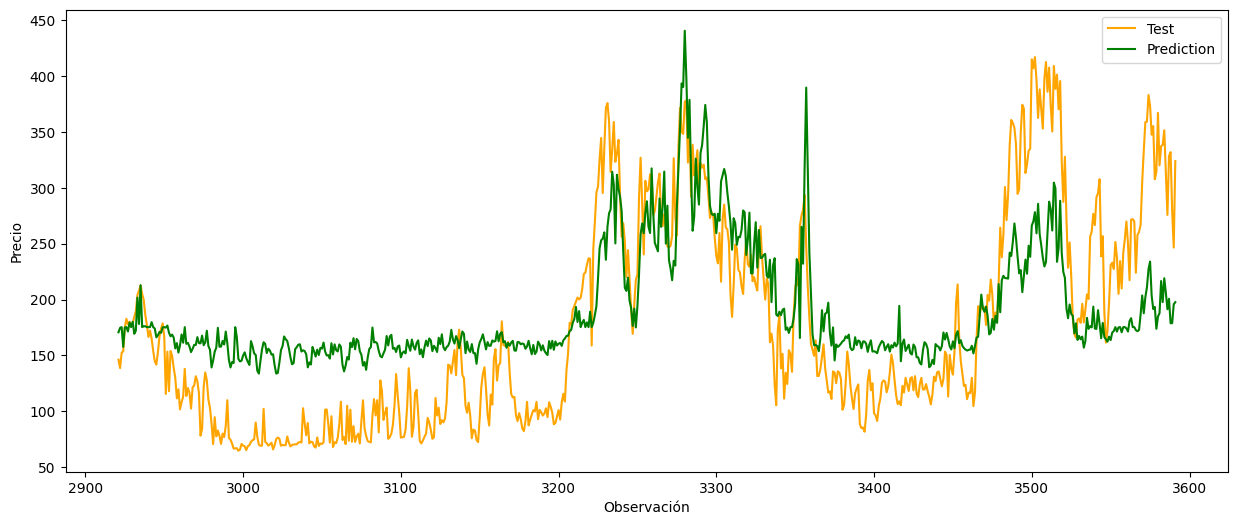

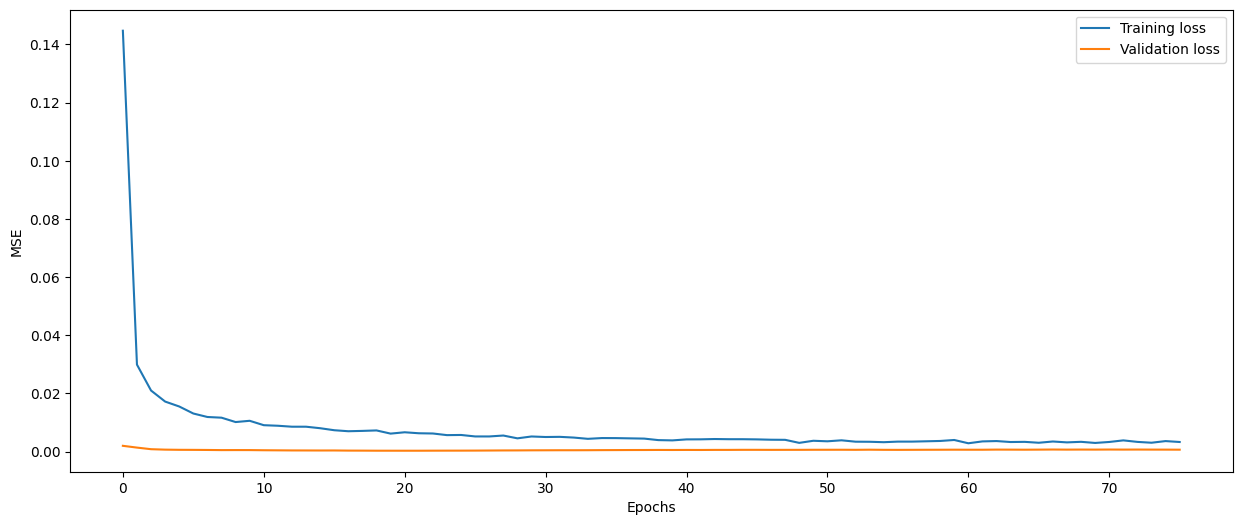

In [21]:
plt.figure(figsize=(15,6))
# plt.plot(X_train_rescaled, label='Train', color='blue')
plt.plot(np.arange(len(X_train_rescaled), len(X_train_rescaled) + len(y_test_rescaled)), y_test_rescaled, label='Test', color='orange')
plt.plot(np.arange(len(X_train_rescaled), len(X_train_rescaled) + len(y_pred_rescaled)), y_pred_rescaled, label='Prediction', color='green')
# plt.xticks(fechas)
plt.xlabel('Observación')
plt.ylabel('Precio')
plt.legend()
plt.show()

plt.figure(figsize=(15,6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')

plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [22]:
index = df.iloc[df.shape[0] - len(y_test_rescaled):, 0].index
predictions_df = pd.DataFrame(data = {'Precio de Bolsa Original': y_test_rescaled, 'Precio de Bolsa Predicho': y_pred_rescaled}, index = index)
predictions_df = predictions_df.iloc[:elementos_a_predecir[0] , :]
predictions_df.to_csv(os.path.join(abspath,"models", "results",f"{modelos_implementar[0]}_iterations_prediction.xlsx"))
predictions_df

,Precio de Bolsa Original,Precio de Bolsa Predicho
fecha,,
2018-03-01,146.201693,170.702595
2018-03-02,138.680593,174.673508
2018-03-03,152.410880,175.325853
2018-03-04,153.660607,157.617027
2018-03-05,174.575577,175.088249
2018-03-06,182.808030,175.325853
2018-03-07,177.889280,171.425170
2018-03-08,180.072437,179.576050
2018-03-09,177.407810,175.325853
